<a href="https://colab.research.google.com/github/ArtemMusienko/LLM-LlamaIndex/blob/main/LLM_LlamaIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи:

Для начала необходимо установить список зависимостей для используемых библиотек.

Мы это сделаем с помощью файла requirements.txt. Этот подход позволяет зафиксировать версии библиотек, с которыми работает наше программное обеспечение и не волноваться, что изменение версии библиотеки сломает весь наш код:

In [ ]:
%%writefile requirements.txt
transformers>=4.42.0
llama_index==0.10.46
pyvis==0.3.2
Ipython==7.34.0
langchain==0.2.5
langchain_community==0.2.5
llama-index-llms-huggingface==0.2.3
llama-index-embeddings-huggingface==0.2.2
llama-index-embeddings-langchain==0.1.2
llama-index-readers-web
langchain-huggingface==0.0.3
sentencepiece==0.1.99
accelerate==0.31.0
bitsandbytes==0.43.1
peft==0.11.1

# Зависимости
huggingface-hub==0.23.3
torch==2.3.1
numpy==1.25.2
packaging==24.1
pyyaml==6.0.1
requests==2.31.0
tqdm==4.66.4
filelock==3.14.0
regex==2024.5.15
typing-extensions==4.12.2
safetensors==0.4.3
tokenizers==0.19.1

Overwriting requirements.txt


Установим все зависимости в указанном файле:

In [ ]:
!pip install -r requirements.txt

Импортируем необходимые библиотеки:


In [ ]:
import gradio as gr
from llama_index.core import SimpleDirectoryReader, KnowledgeGraphIndex, Settings, StorageContext
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.langchain import LangchainEmbedding
from llama_index.readers.web import BeautifulSoupWebReader
from langchain_huggingface import HuggingFaceEmbeddings
from pyvis.network import Network
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig
from peft import PeftModel, PeftConfig
import torch

Выполним авторизацию на **HuggingFace**, введя сгенерированный токен в настройках профиля:

In [ ]:
from huggingface_hub import login


HF_TOKEN="hf_token"
login(HF_TOKEN, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Так как языковая модель **saiga_mistral_7b_lora** обучена для ведения диалогов, то для нее определены специальные теги.

Сообщения к модели строиться по шаблону:

`<s>{role}\n{content}</s>`,

где `content` - это текст сообщения к модели, `role` - одна из возможных ролей:

*  `system` - системная роль, определяет преднастройки модели
*  `user` - вопросы от пользователей

Для начала генерации ответа необходимо передать шаблон `<s>bot\n`, после чего модель запустит процес генерации.

Так, например, функция ниже `completion_to_prompt` запускает шаблон

`<s>system\n</s>\n<s>user\n{completion}</s>\n<s>bot\n`,

что означает пустой запрос `system` без контента, дальше пользовательский запрос `{completion}` и после роль `bot` запускает генерацию. Генерация будет продолжаться до тех пор, пока модель сама не сгенерирует токен `</s>` (окончания сообщения), либо не будет достигнута длина сообщения равная параметру `max_new_tokens`.

Легко догадаться, что функция `messages_to_prompt` оборачивает наши сообщения в теги в зависимости от роли. При работе с языковыми моделями всегда определяйте эти методы, это хорошая практика. Вы всегда сможете обратиться к модели с запросом и проверить, а не галлюцианирует ли она:


In [ ]:
def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        if message.role == 'system':
            prompt += f"<s>{message.role}\n{message.content}</s>\n"
        elif message.role == 'user':
            prompt += f"<s>{message.role}\n{message.content}</s>\n"
        elif message.role == 'bot':
            prompt += f"<s>bot\n"

    #убедитесь, что мы начинаем с системного запроса, при необходимости вставьте пробел
    if not prompt.startswith("<s>system\n"):
        prompt = "<s>system\n</s>\n" + prompt

    #добавить последнюю подсказку помощника
    prompt = prompt + "<s>bot\n"
    return prompt

def completion_to_prompt(completion):
    return f"<s>system\n</s>\n<s>user\n{completion}</s>\n<s>bot\n"

Определим параметры квантования, создадим конфиг и загрузим базовую модель. Загрузим токенизатор и определим параметры конфига:

In [ ]:
#определяем параметры квантования
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

MODEL_NAME = "IlyaGusev/saiga_mistral_7b" #задаем имя модели

config = PeftConfig.from_pretrained(MODEL_NAME) #создание конфига, соответствующего методу PEFT (в нашем случае LoRA)

#загружаем базовую модель, ее имя берем из конфига для LoRA
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path, #идентификатор модели
    quantization_config=quantization_config, #параметры квантования
    torch_dtype=torch.float16, #тип данных
    device_map="auto" #автоматический выбор типа устройства
)


model = PeftModel.from_pretrained(model, MODEL_NAME, torch_dtype=torch.float16) #загружаем LoRA модель

model.eval() #переводим модель в режим инференса
             #можно не переводить, но явное всегда лучше неявного

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False) #загружаем токенизатор

generation_config = GenerationConfig.from_pretrained(MODEL_NAME) #определим параметры конфигурации модели

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

В класс передаем всё параметры, которые имеются. Перечислим наиболее полезные параметры для генерации:

* **max_new_tokens** - максимальное количество токенов в выходной генерации;

* **num_return_sequences** — количество примеров, из которых выбирается лучший финальный текст, дефолтное значение - 5;

* **no_repeat_ngram_size** — все **ngrams** такого размера могут встречаться только один раз, используется как защита от повторов, дефолтное значение - 5;

* **repetition_penalty** — используется система штрафов за повторение токенов, которые надавно уже были сгенерированы. Тем самым модель не повторяется, ищет более креативные ответы.  Дефолтное значение - 2.0;

* **temperature** - влияет на креативность модели. Более низкие температуры дают последовательные и предсказуемые результаты, а более высокие температуры вносят случайность, что приводит к более творческим результатам. При температуре 0 модель выдаёт "почти" один и тот же результат. Однако при более высоких температурах модель выводит слова, которые менее часто встречаются в текстах, на которых она обучалась. По умолчанию - 1;

* **top_k** — параметр **top_k** определяет из какого числа токенов с наибольшей вероятностью выбираем с учетом температуры. При низких температурах выбор в начале диапазона, при высоких - в конце диапазона. Дефолтное значение - 50;

* **top_p** — параметр выбора токенов с наибольшей вероятностью. У токенов в порядке убывания вероятностей суммируются вероятности нарастающим итогом и выбирается из диапазона пока сумма меньше **top_p**. Чем ниже значение  **top_p**, тем более стандартными являются ответы, генерируемые моделью. Общая рекомендация — изменить либо температуру, либо **top_p**, но не то и другое. По умолчанию - 1;

* **do_sample** - использовать выборку токенов (**True**) или "жадное" декодирование (**False**). По умолчанию **False**. При использовании **temperature, top_k и top_p** его необходимо установить в **True**, иначе параметры будут проигнорированы.


Также передаем в класс ранее объявленные вспомогательные функции.

In [ ]:
llm = HuggingFaceLLM(
    model=model, #модель
    model_name=MODEL_NAME, #идентификатор модели
    tokenizer=tokenizer, #токенизатор
    max_new_tokens=generation_config.max_new_tokens, #параметр необходимо использовать здесь, и не использовать в generate_kwargs, иначе ошибка двойного использования
    model_kwargs={"quantization_config": quantization_config}, #параметры квантования
    generate_kwargs = {  #параметры для инференса
      "bos_token_id": generation_config.bos_token_id, #токен начала последовательности
      "eos_token_id": generation_config.eos_token_id, #токен окончания последовательности
      "pad_token_id": generation_config.pad_token_id, #токен пакетной обработки (указывает, что последовательность ещё не завершена)
      "no_repeat_ngram_size": generation_config.no_repeat_ngram_size,
      "repetition_penalty": generation_config.repetition_penalty,
      "temperature": generation_config.temperature,
      "do_sample": True,
      "top_k": 50,
      "top_p": 0.95
    },
    messages_to_prompt=messages_to_prompt, #функция для преобразования сообщений к внутреннему формату
    completion_to_prompt=completion_to_prompt, #функции для генерации текста
    device_map="auto", #автоматически определять устройство
)

Определяем модель внедрения `embed_model` на базе модели `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`. Она необходима для преобразования текста в числовое представление информации. Дальше из этих чисел наша модель построит графы и сохранит их в графовое хранилище.

Также настроим окружение для **LlamaIndex**:

In [ ]:
#настройка эмбеддинга
embed_model = LangchainEmbedding(
    HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
)

#настройка ServiceContext (глобальная настройка параметров LLM)
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = 512

global_index = None #глобальная переменная для хранения индекса

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Создадим функцию `parse_data`. В нем мы будем применять ридер `BeautifulSoupWebReader()` и загрузим данные по url. Далее мы воспользуемся графовым хранилищем, запустим генерацию индексов из документа с помощью `KnowlegeGraphIndex` и выполним генерацию визуализации графа:

In [ ]:
def parse_data(url):
    global global_index

    try:
        reader = BeautifulSoupWebReader()
        documents = reader.load_data([url]) #загружаем данные по url

        graph_store = SimpleGraphStore() #создаем простое графовое хранилище
        storage_context = StorageContext.from_defaults(graph_store=graph_store) #устанавливаем информацию о хранилище в StorageContext

        indexKG = KnowledgeGraphIndex.from_documents(documents=documents, #данные для построения графов
                                                  max_triplets_per_chunk=3, #сколько обработывать триплетов связей для каждого блока данных
                                                  show_progress=True, #показывать процесс выполнения
                                                  include_embeddings=True, #включение векторных вложений в индекс для расширенной аналитики
                                                  storage_context=storage_context) #куда сохранять результаты

        #генерация визуализации графа
        g = indexKG.get_networkx_graph(500)
        net = Network(notebook=True, cdn_resources="in_line", directed=True)
        net.from_nx(g)
        html_path = "knowledge_graph.html"
        net.save_graph(html_path)

        global_index = indexKG
        return f"Данные успешно распарсены! Граф сохранен в {html_path}", html_path

    except Exception as e:
        return f"Ошибка: {str(e)}", None

Создадим функцию `run_auery`. В ней мы сформируем промпт и инструкцию по осуществлению нашего запроса:

In [ ]:
def run_query(query):
    global global_index

    if global_index is None:
        return "Сначала распарсьте данные (кнопка 'Распарсить данные')"

    try:
        query_engine = global_index.as_query_engine(include_text=True, verbose=True)
        message_template = f"""<s>system
Отвечай в соответствии с Источником. Проверь, есть ли в Источнике упоминания о ключевых словах Вопроса.
Если нет, то просто скажи: 'я не знаю'. Не придумывай! Ответ должен быть кратким, но содержательным! </s>
<s>user
Вопрос: {query}
Источник прикрепляю к промпту:
</s>
"""
        response = query_engine.query(message_template)
        return response.response

    except Exception as e:
        return f"Ошибка запроса: {str(e)}"

Настроим **Gradio** интерфейс:

In [ ]:
with gr.Blocks(title="Анализ графа знаний") as demo:
    gr.Markdown("## Анализ графа знаний из веб-страниц")

    with gr.Row():
        url_input = gr.Textbox(
            label="URL страницы",
            value="https://ru.wikipedia.org/wiki/TensorFlow"
        )
        parse_btn = gr.Button("Распарсить данные")

    parse_output = gr.Textbox(label="Статус парсинга")
    graph_output = gr.HTML(label="Визуализация графа")

    with gr.Row():
        query_input = gr.Textbox(
            label="Ваш запрос",
            value="Что ты знаешь об Алане Тьюринге?"
        )
        query_btn = gr.Button("Отправить запрос")

    answer_output = gr.Textbox(label="Ответ системы", lines=5)

    #обработчики событий
    parse_btn.click(
        fn=parse_data,
        inputs=url_input,
        outputs=[parse_output, graph_output]
    )

    query_btn.click(
        fn=run_query,
        inputs=query_input,
        outputs=answer_output
    )

#запуск приложения
if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ba7f3d0d45479e1ac3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


В результате мы получим следующий ответ системы:

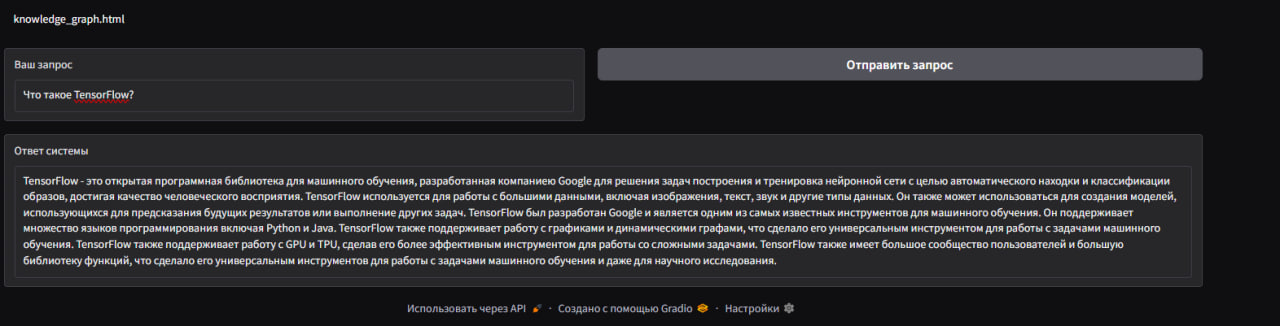